In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import numpy as np
import os.path as osp
from tf_lab.iclr.evaluator import Evaluator
from general_tools.in_out.basics import files_in_subdirs
from geo_tool import Point_Cloud
from tf_lab.iclr.helper import stored_synthetic_samples
from tf_lab.evaluate.generative_pc_nets import coverage
from collections import defaultdict
import collections
from tf_lab.point_clouds.convenience import compute_structural_loss

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
class_name = 'chair'
boost_samples = 3

In [5]:
best_by_jsd = {'r_gan': 1700,
               'l_gan_chamfer': 300,
               'l_gan_emd': 100
              }

In [6]:
evaluator = Evaluator(class_name)
evaluator.load_gt_data()

In [7]:
corr_stats = collections.namedtuple('corr_stats', 'samples matched_id matched_dist');

In [8]:
split = 'val'
gt_data = evaluator.gt_data[split].copy()
chamfer_correspondences = defaultdict(corr_stats)

for model_name in best_by_jsd:
    print model_name    
    top_sample_dir = stored_synthetic_samples(class_name)[model_name]    
    
    if 'gan' in model_name:
        epoch = best_by_jsd[model_name]
        sample_file = osp.join(top_sample_dir, 'epoch_%d.npz' % (epoch,))
    elif 'gmm' in experiment_name:
        gaussian_type = best_by_jsd[model_name]
        sample_file = osp.join(top_sample_dir, gaussian_type + '.npz')
    else:
        assert False

    evaluator.prepare_sample_data(sample_file, boost_samples)
    samples_to_cmp = evaluator.sample_data[split].copy()    
    n_samples = len(samples_to_cmp)
    batch_size = n_samples
        
    mathed_idx, matched_dists = coverage(gt_data, samples_to_cmp, 
             batch_size=batch_size, normalize= True, 
             use_EMD=False, ret_dist=True)

    mathed_idx = np.array(mathed_idx)
    matched_dists = np.array(matched_dists)
    chamfer_correspondences[model_name] = corr_stats(samples_to_cmp, mathed_idx, matched_dists)

l_gan_chamfer
r_gan
l_gan_emd


In [9]:
r_gan_winners = [] # holds gt ids
r_winning_samples = []
r_ch_scores = []
emd_lossing_samples = []
emd_ch_scores = []

l_gan_tag = 'l_gan_chamfer'
for i in range(len(gt_data)):
#     if chamfer_correspondences['r_gan'].matched_dist[i] < chamfer_correspondences['l_gan_emd'].matched_dist[i]:
    if chamfer_correspondences['r_gan'].matched_dist[i] < chamfer_correspondences[l_gan_tag].matched_dist[i]:
        r_gan_winners.append(i)
        mi = chamfer_correspondences['r_gan'].matched_id[i]
        r_winning_samples.append(chamfer_correspondences['r_gan'].samples[mi])
        r_ch_scores.append(chamfer_correspondences['r_gan'].matched_dist[i])
        
        mi = chamfer_correspondences[l_gan_tag].matched_id[i]
        emd_lossing_samples.append(chamfer_correspondences[l_gan_tag].samples[mi])
        emd_ch_scores.append(chamfer_correspondences[l_gan_tag].matched_dist[i])
        

r_winning_samples = np.array(r_winning_samples)
r_ch_scores = np.array(r_ch_scores)
emd_lossing_samples = np.array(emd_lossing_samples)
emd_ch_scores = np.array(emd_ch_scores)

In [10]:
gt_samples_ = gt_data[r_gan_winners]

In [11]:
print len(gt_samples_)
print len(gt_data)

129
338


In [13]:
r_emd_scores = compute_emd_loss(gt_samples_, r_winning_samples, 450, 'emd') / float(2048)
l_emd_scores = compute_emd_loss(gt_samples_, emd_lossing_samples, 450, 'emd') / float(2048)

In [15]:
140/ float(338)
np.sum(r_emd_scores < l_emd_scores) / float(len(r_gan_winners))

0.41420118343195267

In [16]:
import matplotlib.pylab as plt
from general_tools.in_out.basics import create_dir

In [38]:
emd_based_exampled

[7]

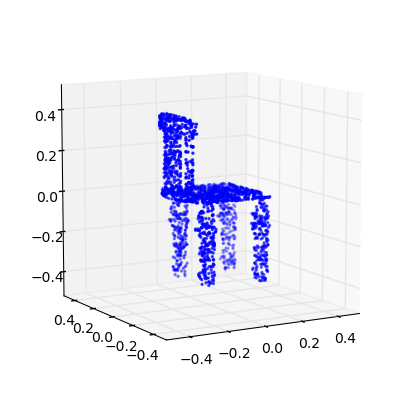

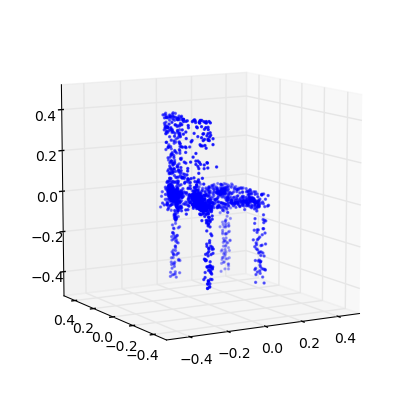

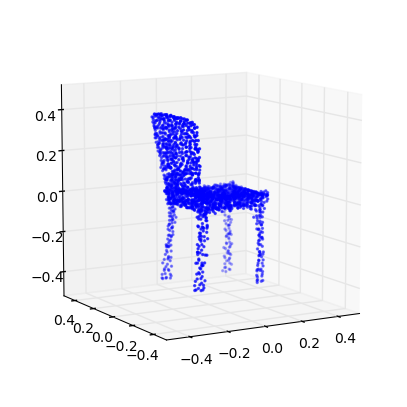

In [43]:
# top_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/demonstrations/chamfer_weakness_hot_spots_2/'+ l_gan_tag
top_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/demonstrations/chamfer_weakness_hot_spots_2/'+ l_gan_tag
create_dir(top_out_dir)
azim = 240
show = True

emd_based_exampled = [np.random.randint(len(gt_samples_))]

for i in emd_based_exampled:
    if r_emd_scores[i] > l_emd_scores[i]:
        out_dir = osp.join(top_out_dir, str(i))
        create_dir(out_dir)
        out_f = osp.join(out_dir, 'gt')
        fig = Point_Cloud(gt_samples_[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', gt_samples_[i])
        
        out_f = osp.join(out_dir, 'raw_gan')
        fig = Point_Cloud(r_winning_samples[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', r_winning_samples[i])
        
        out_f = osp.join(out_dir, l_gan_tag)
        fig = Point_Cloud(emd_lossing_samples[i]).plot(show=show, azim=azim)
        fig.savefig(out_f)
        plt.close()
        np.savetxt(out_f + '.txt', emd_lossing_samples[i])
        
        with open(osp.join(out_dir, 'scores.txt'), 'w') as fout:
            fout.write('Chamfer scores (raw, latent):\n')
            fout.write('%f %f\n' % (r_ch_scores[i], emd_ch_scores[i]))
            fout.write('EMD scores (raw, latent):\n')
            fout.write('%f %f\n' % (r_emd_scores[i], l_emd_scores[i]))

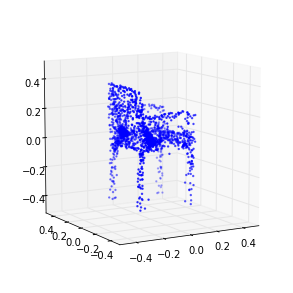

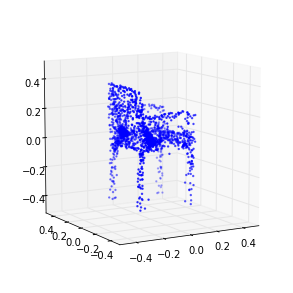

In [128]:
pcf = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/demonstrations/chamfer_weakness_hot_spots/l_gan_emd/113/raw_gan.txt'
pc = np.loadtxt(pcf)
Point_Cloud(pc).plot()